In [ ]:
# !pip install "qiskit" "qiskit-ibm-runtime" "qiskit_serverless" "qiskit-ibm-catalog" "qiskit-ibm-transpiler"

In [ ]:
# !pip install pylatexenc #per permettere la rappresentazione del circuito(draw())

In [ ]:
# !pip install --upgrade "qiskit-aer"

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler
API="FXZooK6PKXZ4Jk0vtF18EZ7qf4UqAnnSgzXJHlanJPtd"
CRN="crn:v1:bluemix:public:quantum-computing:us-east:a/86f82340c6464e169cf352545f3619de:bf97c405-53a9-4573-97a7-2fdda0ea88f9::"


service = QiskitRuntimeService(channel="ibm_quantum_platform",
            token=API, # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
            instance=CRN)
deviceName="ibm_torino"
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(f"Using backend: {backend}")
print(backend)

qiskit_runtime_service._discover_account:WARNING:2026-02-11 11:02:12,364: Loading account with the given token. A saved account will not be used.


Using backend: <IBMBackend('ibm_torino')>
<IBMBackend('ibm_torino')>


In [ ]:
service.backends()

[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

Questo è per capire come ottimizzare BENE


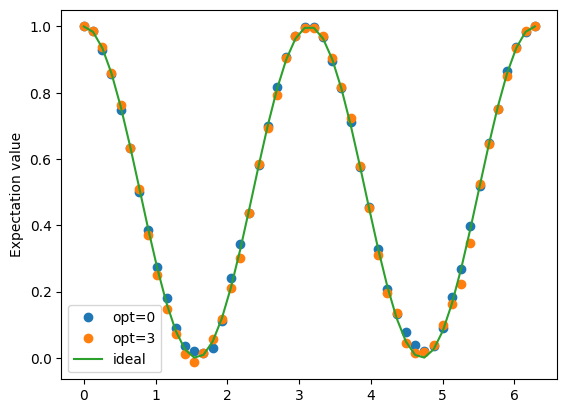

In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorOptions
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from matplotlib import pyplot as plt
from qiskit_ibm_runtime import SamplerV2 as Sampler
from math import pi, asin, sqrt, cos, sin
import numpy as np
import time
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import state_fidelity, DensityMatrix


theta = Parameter("theta")

n_local=4

theta_e=pi                        # valore arbitrario


# 1️⃣  — Crei il tuo circuito logico
creg = ClassicalRegister(n_local, "meas")
qreg = QuantumRegister(n_local + 1, "q")
qc = QuantumCircuit(qreg, creg)   #1 control QUBIT (EXPLORATION), 4 target QUBIT (ANT)...  ; 5 qubits and 4 bits

for i in range(n_local):
  qc.ry((theta), i+1)

for i in range(n_local):
  qc.ry(float(theta_e), 0)
  qc.cx(0, i+1)
  qc.reset(0)



observables = SparsePauliOp.from_list([("ZIIZI", 1)])


phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]
backend_sim = AerSimulator()
#backend_sim = AerSimulator.from_backend(backend)
estimator = Estimator(mode=backend_sim)

circuit = qc




# Use a pass manager to transpile the circuit and observable for the backend being simulated.
# Start with no optimization:


pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout=isa_circuit.layout)

noisy_exp_values = []
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

# Repeat above steps, but now with optimization = 3:

exp_values_with_opt_es = []
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout=isa_circuit.layout)

pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]


plt.plot(phases, noisy_exp_values, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases,np.cos(phases)**2, label="ideal")
plt.ylabel("Expectation value")
plt.legend()
plt.show()




In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorOptions
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from matplotlib import pyplot as plt
from qiskit_ibm_runtime import SamplerV2 as Sampler
from math import pi, asin, sqrt, cos, sin
import numpy as np
import time
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit import Parameter


n_local=4
theta_ant=[pi]*n_local
theta_e=pi                         # valore arbitrario
seed=50                               # seed per la reproducibilità

# 1️⃣  — Crei il tuo circuito logico
creg = ClassicalRegister(n_local, "meas")
qreg = QuantumRegister(n_local + 1, "q")
qc = QuantumCircuit(qreg, creg)   #1 control QUBIT (EXPLORATION), 4 target QUBIT (ANT)...  ; 5 qubits and 4 bits

for i in range(n_local):
  qc.ry(float(theta_ant[i]), i+1)

for i in range(n_local):
  qc.ry(float(theta_e), 0)
  qc.cx(0, i+1)
  qc.reset(0)

for i in range(n_local):
  qc.measure(qreg[i+1], creg[i])


# qc.draw("mpl")

        # (D) esecuzione con AerSimulator
sim = AerSimulator()
t_qc = transpile(qc, sim)

run_args = {"shots": int(1024)}
job = sim.run(t_qc, **run_args)
result = job.result()
counts = result.get_counts()


    # invertiamo per ottenere ordine naturale q0..q_{n-1}

    #Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring = max(counts, key=counts.get)
if isinstance(bitstring, bytes):
   bitstring = bitstring.decode("utf-8")

    # Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring = ''.join(ch for ch in bitstring if ch in ('0', '1'))
measured_bits = [int(b) for b in bitstring[::-1]]

print("Bitstring misurata_AER:", bitstring, "→", measured_bits)

cmap = CouplingMap(backend.configuration().coupling_map)

# Create the SabreLayout passes for the custom configurations
sl_2 = SabreLayout(
    coupling_map=cmap,
    seed=seed,
    max_iterations=4,
    layout_trials=200,
    swap_trials=200,
)
sl_3 = SabreLayout(
    coupling_map=cmap,
    seed=seed,
    max_iterations=8,
    layout_trials=200,
    swap_trials=200,
)

# Create the pass managers, need to first create then configure the SabreLayout passes
pm_1 = generate_preset_pass_manager(
    optimization_level=0, backend=backend, seed_transpiler=seed
)
pm_default_l3 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_2 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)
pm_3 = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=seed
)

pm_2.layout.replace(index=2, passes=sl_2)
pm_3.layout.replace(index=2, passes=sl_3)






# Transpile the circuit with each pass manager and measure the time
t0 = time.time()
tqc_1 = pm_1.run(qc)
t1 = time.time() - t0

t0 = time.time()
tqc_default_l3 = pm_default_l3.run(qc)
t_default_l3 = time.time() - t0

t0 = time.time()
tqc_2 = pm_2.run(qc)
t2 = time.time() - t0

t0 = time.time()
tqc_3 = pm_3.run(qc)
t3 = time.time() - t0

# Obtain the depths and the total number of gates (circuit size)
depth_1 = tqc_1.depth(lambda x: x.operation.num_qubits == 2)
depth_2 = tqc_2.depth(lambda x: x.operation.num_qubits == 2)
depth_3 = tqc_3.depth(lambda x: x.operation.num_qubits == 2)
size_1 = tqc_1.size()
size_2 = tqc_2.size()
size_3 = tqc_3.size()

depth_default_l3 = tqc_default_l3.depth(lambda x: x.operation.num_qubits == 2)
size_default_l3 = tqc_default_l3.size()


def count_two_qubit_gates(circ):
    count = 0
    for inst, qargs, cargs in circ.data:
        if inst.num_qubits == 2:
            count += 1
    return count

twoq_1 = count_two_qubit_gates(tqc_1)
twoq_default_l3 = count_two_qubit_gates(tqc_default_l3)
twoq_2 = count_two_qubit_gates(tqc_2)
twoq_3 = count_two_qubit_gates(tqc_3)

# Compute improvements compared to pass manager 1 (default)
depth_improvement_2 = ((depth_1 - depth_2) / depth_1) * 100
depth_improvement_3 = ((depth_1 - depth_3) / depth_1) * 100
size_improvement_2 = ((size_1 - size_2) / size_1) * 100
size_improvement_3 = ((size_1 - size_3) / size_1) * 100
time_increase_2 = ((t2 - t1) / t1) * 100
time_increase_3 = ((t3 - t1) / t1) * 100

depth_improvement_3_default_l3 = ((depth_1 - depth_default_l3) / depth_1) * 100

size_improvement_3_default_l3 = ((size_1 - size_default_l3) / size_1) * 100

time_increase_3_default_l3 = ((t_default_l3 - t1) / t1) * 100


print(
    f"Pass manager 1 (4,20,20)  : Depth {depth_1}, Size {size_1}, Time {t1:.4f} s"
)

print(
    f"Pass manager default_l3  : Depth {depth_default_l3}, Size {size_default_l3}, Time {t_default_l3:.4f} s"
)
print(f"  - Depth improvement: {depth_improvement_3_default_l3:.2f}%")
print(f"  - Size improvement: {size_improvement_3_default_l3:.2f}%")
print(f"  - Time increase: {time_increase_3_default_l3:.2f}%")

print(
    f"Pass manager 2 (4,200,200): Depth {depth_2}, Size {size_2}, Time {t2:.4f} s"
)
print(f"  - Depth improvement: {depth_improvement_2:.2f}%")
print(f"  - Size improvement: {size_improvement_2:.2f}%")
print(f"  - Time increase: {time_increase_2:.2f}%")
print(
    f"Pass manager 3 (8,200,200): Depth {depth_3}, Size {size_3}, Time {t3:.4f} s"
)
print(f"  - Depth improvement: {depth_improvement_3:.2f}%")
print(f"  - Size improvement: {size_improvement_3:.2f}%")
print(f"  - Time increase: {time_increase_3:.2f}%")

isa_circuit_1 = pm_1.run(qc)
isa_circuit_2 = pm_2.run(qc)
isa_circuit_3 = pm_3.run(qc)
isa_circuit_default_l3 =pm_default_l3.run(qc)
# isa_circuit_default_l3.draw("mpl", idle_wires=False)
# isa_circuit_1.draw("mpl", idle_wires=False)
# isa_circuit_2.draw("mpl", idle_wires=False)
# isa_circuit_3.draw("mpl", idle_wires=False)



# --- Esecuzione con Sampler ---
sampler = Sampler(backend)
job_1 = sampler.run([isa_circuit_1], shots=1024)  # 1024 misure
result_1 = job_1.result()
# Get results for the first (and only) PUB
pub_result_1 = result_1[0]
# Get counts from the classical register "meas".
#print(
#    f" >> First ten results for the meas output register: {pub_result.data.meas.get_bitstrings()[:50]} \n"
#)
counts_1 = pub_result_1.data.meas.get_counts()

job_2 = sampler.run([isa_circuit_2], shots=1024)  # 1024 misure
result_2 = job_2.result()
# Get results for the first (and only) PUB
pub_result_2 = result_2[0]
# Get counts from the classical register "meas".
#print(
#    f" >> First ten results for the meas output register: {pub_result.data.meas.get_bitstrings()[:50]} \n"
#)
counts_2 = pub_result_2.data.meas.get_counts()


job_3 = sampler.run([isa_circuit_3], shots=1024)  # 1024 misure
result_3 = job_3.result()
# Get results for the first (and only) PUB
pub_result_3 = result_3[0]
# Get counts from the classical register "meas".
#print(
#    f" >> First ten results for the meas output register: {pub_result.data.meas.get_bitstrings()[:50]} \n"
#)
counts_3 = pub_result_3.data.meas.get_counts()

job_default_l3 = sampler.run([tqc_default_l3], shots=1024)
result_default_l3 = job_default_l3.result()
pub_result_default_l3 = result_default_l3[0]
counts_default_l3 = pub_result_default_l3.data.meas.get_counts()
# invertiamo per ottenere ordine naturale q0..q_{n-1}

#Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring_1 = max(counts_1, key=counts_1.get)
if isinstance(bitstring_1, bytes):
  bitstring_1 = bitstring_1.decode("utf-8")

# Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring_1 = ''.join(ch for ch in bitstring_1 if ch in ('0', '1'))
measured_bits_1 = [int(b) for b in bitstring_1[::-1]]

#Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring_2 = max(counts_2, key=counts_2.get)
if isinstance(bitstring_2, bytes):
  bitstring_2 = bitstring_2.decode("utf-8")

# Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring_2 = ''.join(ch for ch in bitstring_2 if ch in ('0', '1'))
measured_bits_2 = [int(b) for b in bitstring_2[::-1]]

#Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring_3 = max(counts_3, key=counts_3.get)
if isinstance(bitstring_3, bytes):
  bitstring_3 = bitstring_3.decode("utf-8")

# Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring_3 = ''.join(ch for ch in bitstring_3 if ch in ('0', '1'))
measured_bits_3 = [int(b) for b in bitstring_3[::-1]]

#Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring_default_l3 = max(counts_default_l3, key=counts_default_l3.get)
if isinstance(bitstring_default_l3, bytes):
  bitstring_default_l3 = bitstring_default_l3.decode("utf-8")

# Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring_default_l3 = ''.join(ch for ch in bitstring_default_l3 if ch in ('0', '1'))
measured_bits_default_l3 = [int(b) for b in bitstring_default_l3[::-1]]

target_string = bitstring  # ← METTI QUI la tua soluzione corretta
shots = 1024
# metriche per capire quanto è ottimizzato il circuito

#depth_auto = isa_circuit.depth()
#cz_auto = isa_circuit.count_ops().get('cz', 0)
#swap_auto = isa_circuit.count_ops().get('swap', 0)

#score_auto = (1/(1+depth_auto)) + (1/(1+cz_auto)) + (1/(1+swap_auto))

# stampe varie



print("Bitstring misurata 1:", bitstring_1, "→", measured_bits_1)
#print("Counts del circuito quantistico 1:  \n", counts_1)
print("Bitstring misurata 2:", bitstring_2, "→", measured_bits_2)
#print("Counts del circuito quantistico 2:  \n", counts_2)
print("Bitstring misurata 3:", bitstring_3, "→", measured_bits_3)
#print("Counts del circuito quantistico 3:  \n", counts_3)
print("Bitstring misurata default_l3:", bitstring_default_l3, "→", measured_bits_default_l3)

def get_target_prob(counts, target, shots):
    return counts.get(target, 0) / shots

prob_1 = get_target_prob(counts_1, target_string, shots)
prob_default_l3 = get_target_prob(counts_default_l3, target_string, shots)
prob_2 = get_target_prob(counts_2, target_string, shots)
prob_3 = get_target_prob(counts_3, target_string, shots)



print("\n===== COMPARISON SUMMARY =====")

print(f"\nL0:")
print(f"  2Q Depth: {depth_1}")
print(f"  Size: {size_1}")
print(f"  2Q gates: {twoq_1}")
print(f"  Transpile Time: {t1:.4f} s")
print(f"  Target Probability: {prob_1:.4f}")

print(f"\nL3 Default:")
print(f"  2Q Depth: {depth_default_l3}")
print(f"  Size: {size_default_l3}")
print(f"  2Q gates: {twoq_default_l3}")
print(f"  Transpile Time: {t_default_l3:.4f} s")
print(f"  Target Probability: {prob_default_l3:.4f}")

print(f"\nL3 Custom (4 iter):")
print(f"  2Q Depth: {depth_2}")
print(f"  Size: {size_2}")
print(f"  2Q gates: {twoq_2}")
print(f"  Transpile Time: {t2:.4f} s")
print(f"  Target Probability: {prob_2:.4f}")

print(f"\nL3 Aggressive (8 iter):")
print(f"  2Q Depth: {depth_3}")
print(f"  Size: {size_3}")
print(f"  2Q gates: {twoq_3}")
print(f"  Transpile Time: {t3:.4f} s")
print(f"  Target Probability: {prob_3:.4f}")




Bitstring misurata_AER: 0000 → [0, 0, 0, 0]


/tmp/ipython-input-3123745899.py:190: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in circ.data:


Pass manager 1 (4,20,20)  : Depth 13, Size 103, Time 0.0040 s
Pass manager default_l3  : Depth 7, Size 44, Time 0.0093 s
  - Depth improvement: 46.15%
  - Size improvement: 57.28%
  - Time increase: 133.75%
Pass manager 2 (4,200,200): Depth 7, Size 44, Time 0.0918 s
  - Depth improvement: 46.15%
  - Size improvement: 57.28%
  - Time increase: 2207.37%
Pass manager 3 (8,200,200): Depth 6, Size 47, Time 0.0903 s
  - Depth improvement: 53.85%
  - Size improvement: 54.37%
  - Time increase: 2170.07%
Bitstring misurata 1: 0000 → [0, 0, 0, 0]
Bitstring misurata 2: 0000 → [0, 0, 0, 0]
Bitstring misurata 3: 0010 → [0, 1, 0, 0]
Bitstring misurata default_l3: 0000 → [0, 0, 0, 0]

===== COMPARISON SUMMARY =====

L0:
  2Q Depth: 13
  Size: 103
  2Q gates: 13
  Transpile Time: 0.0040 s
  Target Probability: 0.8242

L3 Default:
  2Q Depth: 7
  Size: 44
  2Q gates: 7
  Transpile Time: 0.0093 s
  Target Probability: 0.4629

L3 Custom (4 iter):
  2Q Depth: 7
  Size: 44
  2Q gates: 7
  Transpile Time: 0

In [ ]:
!pip install qiskit-ibm-transpiler[ai-local-mode]

AI transpilation parameters : Depth 12, Size 61, Time 0.5013 s
Bitstring misurata AI: 0000 → [0, 0, 0, 0]


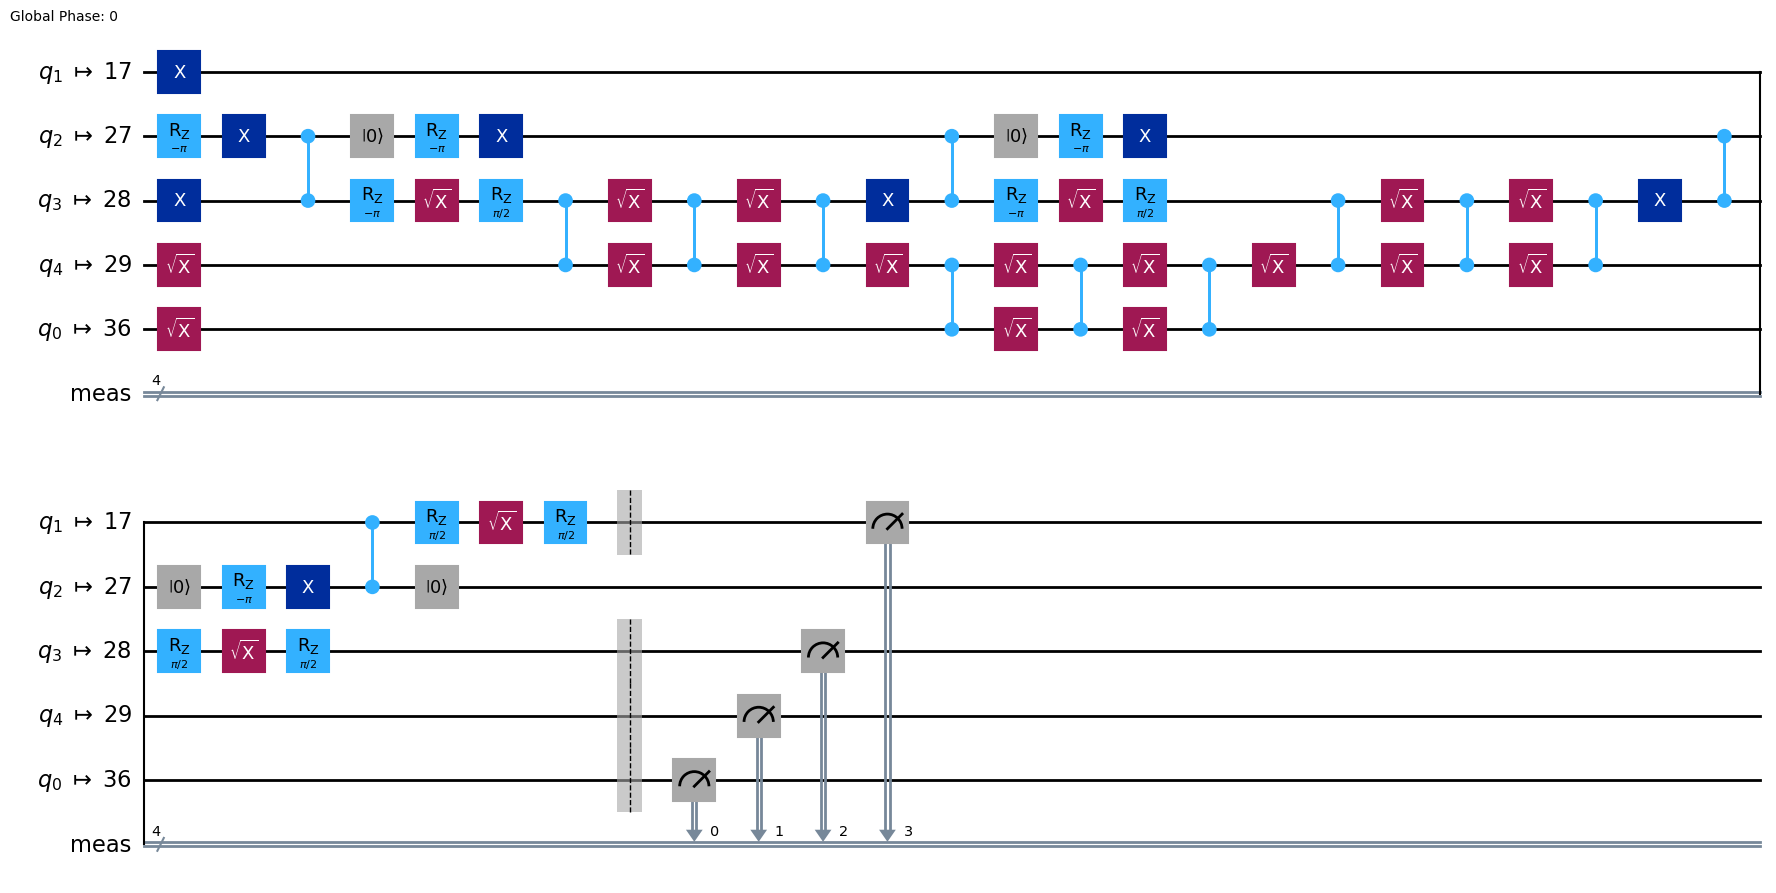

In [ ]:
from qiskit.transpiler import PassManager
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_transpiler import generate_ai_pass_manager
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_catalog import QiskitServerless, QiskitFunction
from qiskit_ibm_runtime import EstimatorOptions
from qiskit.transpiler import CouplingMap
from matplotlib import pyplot as plt
from qiskit_ibm_runtime import SamplerV2 as Sampler
from math import pi, asin, sqrt, cos, sin
import numpy as np
import time
from qiskit import transpile
from qiskit.transpiler import Layout

n_local=4
theta_ant=[3*pi/2]*n_local
theta_e=pi                      # valore arbitrario
seed=42                               # seed per la reproducibilità

# 1️⃣  — Crei il tuo circuito logico
creg = ClassicalRegister(n_local, "meas")
qreg = QuantumRegister(n_local + 1, "q")
qc = QuantumCircuit(qreg, creg)   #1 control QUBIT (EXPLORATION), 4 target QUBIT (ANT)...  ; 5 qubits and 4 bits

for i in range(n_local):
  qc.ry(float(theta_ant[i]), i+1)

for i in range(n_local):
  qc.ry(float(theta_e), 0)
  qc.cx(0, i+1)
  qc.reset(0)

for i in range(n_local):
  qc.measure(qreg[i+1], creg[i])


coupling_map = backend.coupling_map

ai_transpiler_pass_manager = generate_ai_pass_manager(
    #coupling_map=coupling_map,
    backend=backend,
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="improve",
)

transpiled_circuit = ai_transpiler_pass_manager.run(qc)

t0 = time.time()
tqc_AI= ai_transpiler_pass_manager.run(qc)
t_AI= time.time() - t0
depth_AI = tqc_AI.depth(lambda x: x.operation.num_qubits == 2)
size_AI = tqc_AI.size()

print(
    f"AI transpilation parameters : Depth {depth_AI}, Size {size_AI}, Time {t_AI:.4f} s"
)

isa_circuit_AI = ai_transpiler_pass_manager.run(qc)

# # ✅ Estrai il layout scelto
# layout_opt = isa_circuit_AI.layout

isa_circuit_AI.draw("mpl", idle_wires=False)

# --- Esecuzione con Sampler ---
sampler = Sampler(backend)
job_AI = sampler.run([isa_circuit_AI], shots=1024)  # 1024 misure
result_AI = job_AI.result()

pub_result_AI = result_AI[0]

counts_AI = pub_result_AI.data.meas.get_counts()


#Prendi la bitstring più frequente e assicurati che sia stringa normale
bitstring_AI = max(counts_AI, key=counts_AI.get)
if isinstance(bitstring_AI, bytes):
  bitstring_AI = bitstring_AI.decode("utf-8")

# Mantieni solo 0/1 e inverti (Qiskit restituisce l’ordine inverso dei qubit)
bitstring_AI = ''.join(ch for ch in bitstring_AI if ch in ('0', '1'))
measured_bits_AI = [int(b) for b in bitstring_AI[::-1]]



print("Bitstring misurata AI:", bitstring_AI, "→", measured_bits_AI)
